# Statistical Parameter Estimation 2024
## Exercise 6

Author: Alex Karonen

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Consider the following non-linear state space model:

$$
    \begin{split}
    x_k &= x_{k-1} - 0.01 sin(x{k-1}) + q_{k-1}, \\
    y_k &= 0.5 ~sin(2 x_k) + r_k \\
    \end{split}
$$,
where $q_{k-1}$ has a variance of $0.01^2$
and $r_k$ has a variance of $0.02$. 
Derive the required derivatives for an EKF and implement the EKF for the model.
Simulate trajectories from the model, compute the RMSE values, and plot the result.

In [2]:
Q = 0.01**2
R = 0.02**2

N = 100
k = np.linspace(0, 1, N)

x_k = np.zeros(shape=N)
y_k = np.zeros(shape=(N - 1))

f = lambda x: x - 0.01 * np.sin(x)
h = lambda x: 1 / 2 * np.sin(2 * x)
for i in range(1, N):
    x_k[i] = f(x_k[i-1])+ np.random.normal(loc=0, scale=Q)
    y_k[i-1] = h(x_k[i]) + np.random.normal(loc=0, scale=R)

### Required derivatives

$$

\begin{split}
    \bold{f}(\bold{x}_{k-1}) &= x_{k-1}-0.01 \sin(x_{k-1})\\

    \bold{F}_{\bold{x}}(\bold{x}) &= 1-0.01 \cos(x)\\

    \bold{h}(\bold{x}_{k}) &= 0.5 \sin(2x_{k})\\

    \bold{H}_{\bold{x}}(\bold{x}) &= \cos(2x)\\
\end{split}

$$

In [3]:
def prediction(m, f, F_x, P, Q):
    m_k_minus = f(m)
    P_k_minus = F_x(m) * P * F_x(m) + Q
    return m_k_minus, P_k_minus


def update(m, y_k, h, H_x, P, R):
    v_k = y_k - h(m)
    S_k = H_x(m) * P * H_x(m) + R
    K_k = P * H_x(m) * S_k ** (-1)
    m_k = m + K_k * v_k
    P_k = P - K_k * S_k * K_k
    return m_k, P_k

In [4]:
m_0 = 0
P_0 = 0

F_x = lambda x: (1-0.01*np.cos(x))
H_x = lambda x: np.cos(2 * x) 

m_k = np.zeros_like(x_k)
P_k = np.zeros_like(x_k)
x_est = np.zeros(shape=(N))
m_k[0] = m_0
P_k[0] = P_0
x_est[0] = np.random.normal(loc=m_k[0], scale=P_k[0])
for i in range(1, N):
    m_k_minus, P_k_minus = prediction(m_k[i - 1], f, F_x, P_k[i - 1], Q)
    m_k[i], P_k[i] = update(m_k_minus, y_k[i-1], h, H_x, P_k_minus, R)
    x_est[i] = np.random.normal(loc=m_k[i], scale=P_k[i])

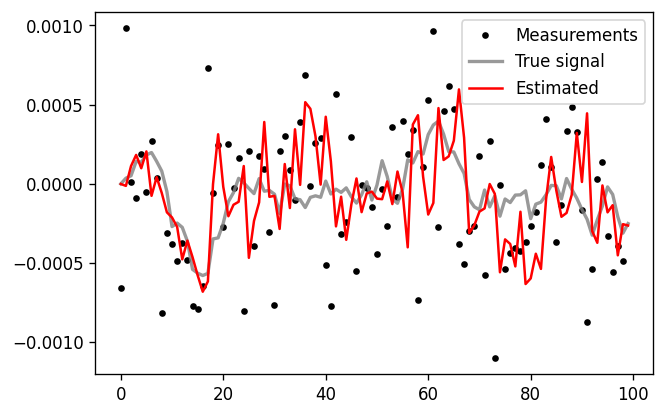

In [5]:
plt.figure(dpi=120)
plt.plot(y_k, 'k.', label='Measurements')
plt.plot(x_k, 'gray', lw=2, alpha=0.8, label="True signal")
plt.plot(x_est, 'r', label="Estimated")
plt.legend()
plt.show()

In [6]:
def rmse(x, y):
    """Root mean square error between two vectors x and y
    Example:
    >>> x = np.ones(10)
    >>> y = np.ones(10) * 0.5
    >>> rmse(x, y)
    0.5
    """
    return np.sqrt(np.mean(np.square(x - y)))

RMSE

In [7]:
print("RMSE of the estimate vs ground truth:", rmse(x_est, x_k))

RMSE of the estimate vs ground truth: 0.0002529951431099964



The state of the target at time step k consists of the position $(x_k, y_k)$ and the
velocity  $(\dot{x}_k, \dot{y}_k)$ The dynamics of the state vector $x_k = (x_k, y_k, \dot{x}_k, \dot{y}_k)^T$
are modeled with the discretized Wiener velocity model:

$$
    \begin{pmatrix}
        x_k\\
        y_k\\
        \dot{x}_k\\
        \dot{y}_k
    \end{pmatrix} =
    
    \begin{pmatrix}
        1 & 0 & \Delta t & 0 \\
        0 & 1 & 0 & \Delta t \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\
    \end{pmatrix}
    \begin{pmatrix}
        x_{k-1}\\
        y_{k-1}\\
        \dot{x}_{k-1}\\
        \dot{y}_{k-1}
    \end{pmatrix}

    + q_{k-1},

$$

where $q_{k-1}$ is a zero mean Gaussian process noise with covariance

$$
    Q = \begin{pmatrix}
            q_1^c \Delta t^3/3& 0 & q_1^c \Delta t^2/2 & 0 \\
            0 & q_2^c \Delta t^3/3 & 0 & q_2^c \Delta t^2/2 \\
            q_1^c \Delta t^2/2 & 0 & q_1^c \Delta t & 0 \\
            0 & q_2^c \Delta t^2/2 & 0 & q_2^c \Delta t \\
        \end{pmatrix}.

$$

In this scenario the diffusion coefficients are $q_1^c=q_2^c = 0.1$ and the sampling period is $\Delta t = 0.1$. The measurement model for sensor $i \in {1,2}$ is:

$$
    \theta_k^i = \tan^{-1}(\frac{y_k-s^i_y}{x_k-s^i_x})+r_k^i,
$$
where $(s^i_x, s^i_y)$ is the position of the sensor $i$, and $r_k^i \sim N(0,\sigma^2)$
is a Gaussian measurement noise with a standard deviation of $\sigma = 0.05$ radians. At
each sampling time, which occurs 10 times per second (i.e., $\Delta t = 0.1$), both
of the two sensors produce a measurement.

Task is to implement an EKF for the problem and compare the results graphically and
in the RMSE sense.

In [8]:
import scipy.stats as stats
import scipy.linalg as linalg

In [9]:
def mv_normal(m, C):
    """Samples a multivariate normal of mean m and covariance C
    Example:
    >>> m = np.array([0., 0.])
    >>> C = np.eye(2)
    >>> mv_normal(m, C).size
    2
    """
    sample = np.random.randn(*m.shape)
    return m + linalg.cholesky(C, lower=True) @ sample

In [10]:
def filter_routine(
    initial_guess, initial_guess_covariance, update_method, observations
):
    """Loops over the observations and calls the implemented update_method
    Example:
    >>> initial_guess = np.array([0, 0])
    >>> initial_covariance = np.eye(2)
    >>> def update_method(x, cov, obs): return x, cov
    >>> observations = np.random.randn(500)
    >>> states, state_covariances = filter_routine(initial_guess, initial_covariance, update_method, observations)
    >>> shape_ok = states.shape[0] == state_covariances.shape[0] == observations.shape[0]
    >>> values_ok = np.all(states == 0)
    >>> values_ok and shape_ok
    True
    """
    T = observations.shape[0]
    x = initial_guess[:]
    cov = initial_guess_covariance[:]

    states = np.empty((T, *x.shape))
    covariances = np.empty((T, *initial_guess_covariance.shape))

    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i, :] = x
        covariances[i, :] = cov

    return states, covariances

In [11]:
def inverse_bearings(s, thetas):
    """We use the fact that tan(\theta_i) Z_y - Z_x = tan(\theta_i) S^i_y - S^i_x
    where Z is the coordinates corresponding to the measured angles to build a system of
    linear equations in the coordinates"""

    tan_theta = np.tan(thetas)
    ones = np.ones_like(thetas)
    matrices = np.stack([tan_theta, -ones], axis=-1)
    target_vectors = np.einsum("ijk,jk->ij", matrices, s)
    return np.linalg.solve(matrices, target_vectors)

In [12]:
def plot_bearings(true_states, thetas, s):
    fig, ax = plt.subplots(figsize=(10, 10))

    observed_positions = inverse_bearings(s, thetas)

    ax.plot(*true_states[:, :2].T, linestyle="--", label="True Signal")
    ax.quiver(
        *true_states[::10].T,
        units="xy",
        scale=5,
        width=0.01,
        label="Velocity every 20 steps"
    )
    ax.scatter(
        *true_states[0, :2], marker="*", s=200, label="Starting point", color="orange"
    )
    ax.scatter(
        *observed_positions.T,
        marker="o",
        facecolors="none",
        s=10,
        label="Observations",
        color="red"
    )
    ax.scatter(*s[0], marker="o", s=200, label="Sensor 1", color="k")
    ax.scatter(*s[1], marker="x", s=200, label="Sensor 2", color="k")

    ax.set_xlabel("Time step")
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="lower left")
    fig.suptitle("Simulated data")

In [13]:
def plot_results(true_states, approx_states, name, title):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.plot(*true_states[:, :2].T, linestyle="--", label="True Signal")
    ax.plot(*approx_states[:, :2].T, linestyle="--", label=name)
    ax.scatter(
        *true_states[0, :2], marker="*", s=200, label="Starting point", color="orange"
    )

    ax.set_xlabel("Time step")
    ax.legend(loc="upper left")
    fig.suptitle(title, y=0.95, fontsize=15)

In [14]:
def generate_trajectory_and_measurements(z_0, s, dt, sigma, steps, random_state):
    """Creates a smooth curvy trajectory and samples the noisy measured angles.

    Parameters
    ----------
    z_0 : (4,) array_like
        Initial position and velocity
    s : (2, 2) array_like
        Location of sensors (s1 = s[0, :], s2 = s[1, :])
    dt : float
        Time between each measurement
    sigma : float
        Observation standard deviation
    steps : int
        Number of steps simulated
    random_state : RandomState
        Random state used for pseudo-random numbers generation

    Returns
    -------
    timeline: (steps) ndarray
        The observation times
    states : (steps, 4) ndarray
        The true states
    thetas : (steps, 2) ndarray
        The noisy angles
    """

    a = np.zeros(steps)
    a[steps // 10 : 2 * steps // 10] = np.pi / 2 / 51 / dt + 0.01 * random_state.randn(
        steps // 10
    )
    a[4 * steps // 10 : 5 * steps // 10] = (
        np.pi / 2 / 51 / dt + 0.01 * random_state.randn(steps // 10)
    )
    a[7 * steps // 10 : 8 * steps // 10] = (
        np.pi / 2 / 51 / dt + 0.01 * random_state.randn(steps // 10)
    )

    z = z_0[:]

    states = np.empty((steps, 4))
    thetas = np.empty((steps, 2))

    for i in range(steps):
        F = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, a[i]], [0, 0, -a[i], 0]])

        expF = linalg.expm(F * dt)
        z = expF @ z
        states[i, :] = z
        thetas[i, 0] = (
            np.arctan2(z[1] - s[0, 1], z[0] - s[0, 0]) + sigma * random_state.randn()
        )
        thetas[i, 1] = (
            np.arctan2(z[1] - s[1, 1], z[0] - s[1, 0]) + sigma * random_state.randn()
        )

    return np.arange(dt, (steps + 1) * dt, dt), states, thetas

In [15]:
random_state = np.random.RandomState(31415926)
sigma = 0.05
dt = 0.01
r = 0.1
z_0 = np.array([0.0, 0.0, 1.0, 0.0])

s_1 = np.array([-1.5, 0.5])
s_2 = np.array([1.0, 1.0])
sensors = np.stack([s_1, s_2])

A = np.array([[1, 0, dt, 0], 
              [0, 1, 0, dt], 
              [0, 0, 1, 0], 
              [0, 0, 0, 1]])
q = 0.1

Q = q * np.array(
    [
        [dt**3 / 3, 0, dt**2 / 2, 0],
        [0, dt**2 / 2, 0, dt**3 / 3],
        [dt**2 / 2, 0, dt, 0],
        [0, dt**2 / 2, 0, dt],
    ]
)

In [16]:
def baseline_update_method(x, cov, theta):
    """A baseline method that inverts the bearings measurement:
    we use a local function similar to inverse_bearings defined above.
    Example:
    >>> x = np.array([0.15, 0., 1., 1.])
    >>> cov = np.eye(4)
    >>> theta = np.array([np.atan(1), -np.atan(1)])
    >>> sensors = np.array([[-1., 0.],
    ...                     [1., 0.]])
    >>> new_x, new_cov = baseline_update_method(x, cov, obs)
    >>> np.allclose(new_x, [0., -1., 0., 0.])
    True
    """
    tan_theta = np.tan(theta)
    ones = np.ones_like(theta)
    matrices = np.stack([tan_theta, -ones], axis=-1)
    target_vectors = np.einsum("jk,jk->j", matrices, sensors)
    res = linalg.solve(matrices, target_vectors)
    return np.concatenate([res, np.zeros_like(res)]), cov

In [17]:
steps = 500

timeline, true_states, thetas = generate_trajectory_and_measurements(
    z_0, sensors, dt, sigma, steps, random_state
)

In [18]:
initial_state = true_states[0]
initial_covariance = np.eye(4)

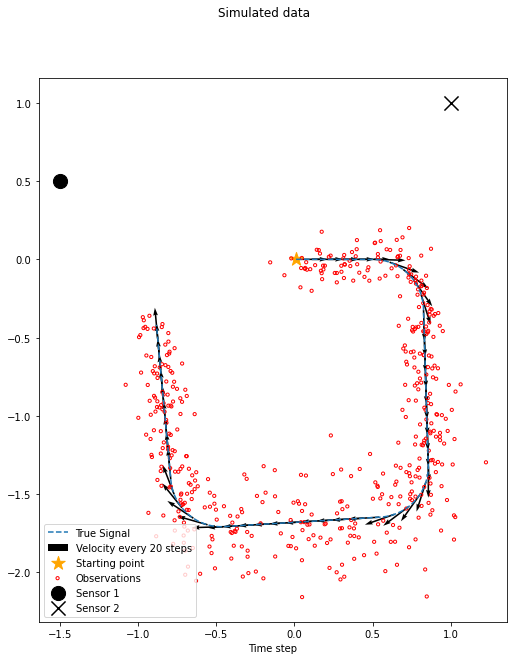

In [19]:
plot_bearings(true_states, thetas, sensors)

In [20]:
baseline_states, _ = filter_routine(
    initial_state, initial_covariance, baseline_update_method, thetas
)

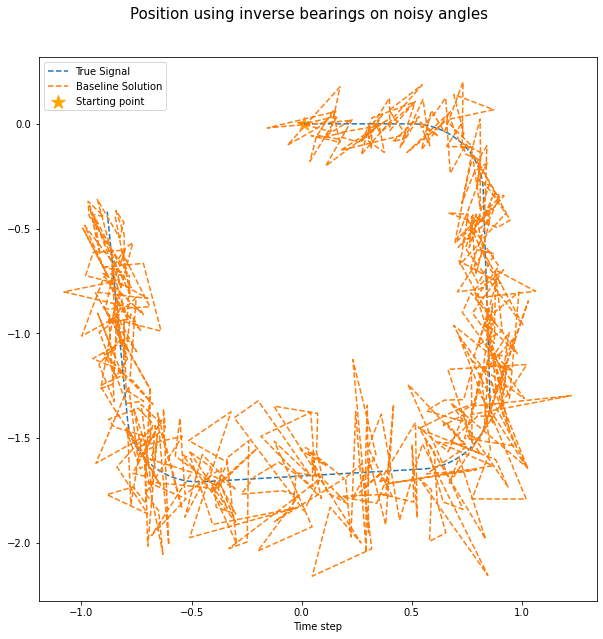

In [21]:
plot_results(
    true_states,
    baseline_states,
    "Baseline Solution",
    "Position using inverse bearings on noisy angles",
)

In [22]:
random_state = np.random.RandomState(31415926)
sigma = 0.05
dt = 0.01
r = 0.1
z_0 = np.array([0.0, 0.0, 1.0, 0.0])

s_1 = np.array([-1.5, 0.5])
s_2 = np.array([1.0, 1.0])
sensors = np.stack([s_1, s_2])

A = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
q = 0.1

Q = q * np.array(
    [
        [dt**3 / 3, 0, dt**2 / 2, 0],
        [0, dt**2 / 2, 0, dt**3 / 3],
        [dt**2 / 2, 0, dt, 0],
        [0, dt**2 / 2, 0, dt],
    ]
)
f = lambda x: A @ x
h = lambda i,x: (
    np.arctan2(x[1] - sensors[i, 1], x[0] - sensors[i, 0]) )

F_x = lambda x: A

dtheta_dx = lambda i, x_k, y_k: (sensors[i, 1] - y_k) / (
    x_k**2 - 2 * x_k * sensors[i, 0] + sensors[i, 0] ** 2 + (sensors[i, 1] - y_k) ** 2
)
dtheta_dy = lambda i, x_k, y_k: -(sensors[i, 0] - x_k) / (
    y_k**2
    - 2 * y_k * sensors[i, 1]
    + sensors[i, 0] ** 2
    - 2 * sensors[i, 0] * x_k
    + sensors[i, 1] ** 2
    + x_k**2
)
H_x = lambda i, x: np.array(
    [
        dtheta_dx(i, x[0], x[1]),
        dtheta_dy(i, x[0], x[1]),
        0,
        0
    ]
)

In [23]:
def prediction(m, f, F_x, P, Q):
    m_k_minus = f(m)
    P_k_minus = F_x(m) @ P @ F_x(m).T + Q
    return m_k_minus, P_k_minus


def update(m, y_k, h, H_x, P, R, i):

    H = H_x(i,m).reshape(-1,1).T
 
    v_k = y_k - h(i,m)

    S_k = H @ P @ H.T + R
    K_k = P @ H.T * S_k**(-1)

    m_k = m + (K_k * v_k).squeeze()
    P_k = P - (K_k * S_k) @ K_k.T

    return m_k, P_k

In [24]:
def ekf_predict_update(x, cov, theta):
    new_x, new_cov = np.zeros_like(x), np.zeros_like(cov) #Initialize new_x and new_cov

    # Update & predict based on the angle of the sensor 1
    m_k_minus, P_k_minus = prediction(x, f, F_x, cov, Q)
    new_x, new_cov = update(m_k_minus, theta[0], h, H_x, P_k_minus, R, 0)

    # Update & predict based on the angle of the sensor 2 with the values from sensor 1
    m_k_minus, P_k_minus = prediction(new_x, f, F_x, new_cov, Q)
    new_x, new_cov = update(m_k_minus, theta[1], h, H_x, P_k_minus, R, 1)

    return new_x, new_cov

In [25]:
ekf_states, ekf_covariances = filter_routine(
    initial_state, initial_covariance, ekf_predict_update, thetas
)

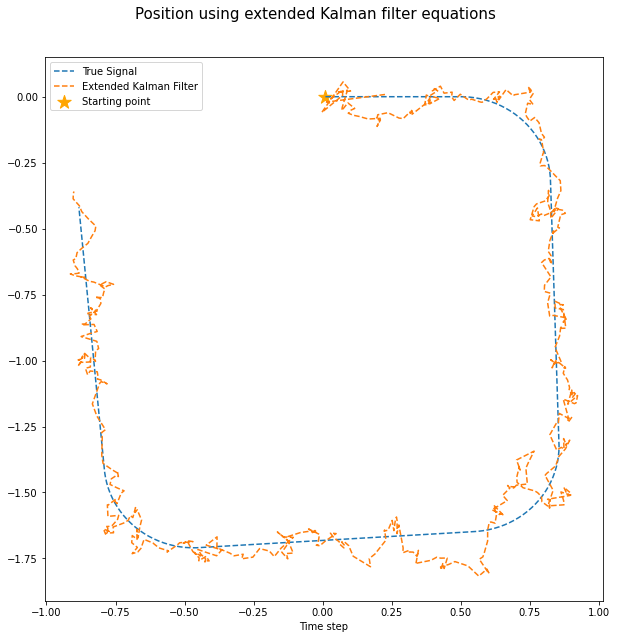

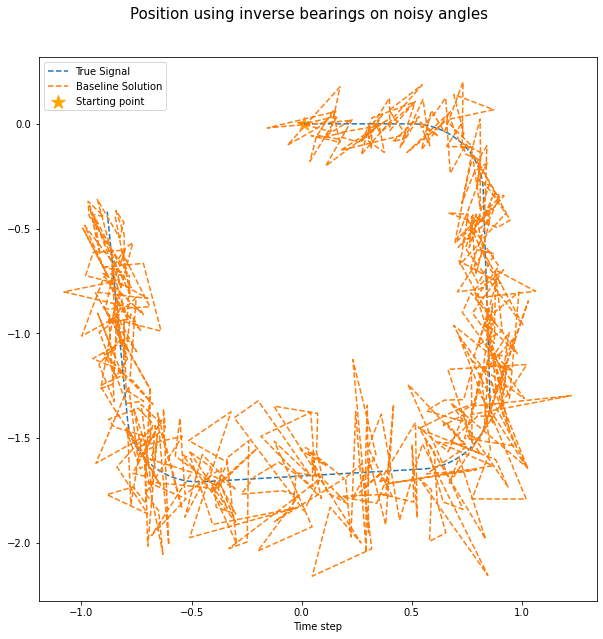

In [29]:

plot_results(
    true_states,
    ekf_states,
    "Extended Kalman Filter",
    "Position using extended Kalman filter equations",
)

plot_results(
    true_states,
    baseline_states,
    "Baseline Solution",
    "Position using inverse bearings on noisy angles",
)

In [30]:
print("RMSE of the EKF estimate vs true signal:", rmse(ekf_states, true_states))

RMSE of the EKF estimate vs true signal: 0.3152354193844825
